## Import Libraries

In [ ]:
!pip install xgboost
!pip install -U imbalanced-learn

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
import torch
import collections
import joblib
import os
import torch.nn as nn
import torch.optim as optim

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

import requests
import re
import gdown

##Load the Files from Github

In [ ]:
data_path = None

try:
    # --- Step 1: Load the raw README from GitHub ---
    github_raw_url = 'https://raw.githubusercontent.com/Anthony-W03/ML_final_project/main/README.md'
    response = requests.get(github_raw_url)
    md_text = response.text

    # --- Step 2: Extract [label](https://drive.google.com/file/d/ID/view) entries ---
    pattern = r'\[([^\]]+)\]\(https://drive\.google\.com/file/d/([a-zA-Z0-9_-]+)'
    matches = re.findall(pattern, md_text)

    # --- Step 3: Map known labels to local filenames ---
    custom_filenames = {
        'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv': 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
        'xgb_weights.pkl': 'xgb_weights.pkl',
        'scaler_weights.pkl': 'scaler_weights.pkl',
        'label_encoder_weights.pkl': 'label_encoder_weights.pkl',
        'gan_fakes.pkl': 'gan_fakes.pkl',
        'augmented_data.pkl':'augmented_data.pkl',
        'generator.pth':'generator.pth',
        'discriminator.pth':'discriminator.pth',
        'generator_weights.pth':'generator_weights.pth',
        'WEIGHTS_DIR':'WEIGHTS_DIR'
    }

    # --- Step 4: Download and assign to variables ---
    for label, file_id in matches:
        label = label.strip()

        # If the label is descriptive, normalize it
        normalized_label = label.replace('Download the ', '').strip()

        # Map to correct filename
        local_filename = custom_filenames.get(normalized_label)
        if not local_filename:
            print(f"Skipping unknown label: {label}")
            continue

        # Download the file
        download_url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Downloading: {normalized_label} → {local_filename}")
        gdown.download(download_url, output=local_filename, quiet=False)

        # Assign to variables
        if normalized_label == 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv':
            data_path = local_filename
        elif normalized_label == 'xgb_weights.pkl':
            MODEL_PATH = local_filename
        elif normalized_label == 'scaler_weights.pkl':
            SCALER_PATH = local_filename
        elif normalized_label == 'label_encoder_weights.pkl':
            ENC_PATH = local_filename
        elif normalized_label == 'gan_fakes.pkl':
            FAKE_PATH = local_filename
        elif normalized_label == 'augmented_data.pkl':
            AUG_PATH = local_filename
        elif normalized_label == 'generator.pth':
            GEN_PATH = local_filename
        elif normalized_label == 'discriminator.pth':
            DISC_PATH = local_filename
        elif normalized_label == 'generator_weights.pth':
            GEN_PATH = local_filename
        elif normalized_label == 'WEIGHTS_DIR':
            WEIGHTS_DIR = local_filename

    print("\n All files downloaded and assigned.")

    # Check if data_path was successfully assigned after the loop
    if data_path is None:
        print("ERROR: Dataset path not set. Check if label or mapping is incorrect.")

except requests.exceptions.RequestException as e:
    print(f"ERROR during download: {e}")
except Exception as e:
    print(f"An unexpected error occurred during download: {e}")

Downloading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv → Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


Downloading...
From: https://drive.google.com/uc?id=1BLHP9C-UINGtOlxfoTMAlhoTSzVo1Krr
To: /content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
100%|██████████| 52.0M/52.0M [00:00<00:00, 75.4MB/s]


Downloading: xgb_weights.pkl → xgb_weights.pkl


Downloading...
From: https://drive.google.com/uc?id=1PlUvsRigILkn2RyetRPfqrWSdkBFzJ6j
To: /content/xgb_weights.pkl
100%|██████████| 3.24M/3.24M [00:00<00:00, 249MB/s]


Downloading: scaler_weights.pkl → scaler_weights.pkl


Downloading...
From: https://drive.google.com/uc?id=101iRWSn149wfjJ42SZ0hfeG0fon76_4X
To: /content/scaler_weights.pkl
100%|██████████| 4.20k/4.20k [00:00<00:00, 10.2MB/s]


Downloading: label_encoder_weights.pkl → label_encoder_weights.pkl


Downloading...
From: https://drive.google.com/uc?id=13aeCtGmtadMzaKNv3GG6Vz-NK68oE4kT
To: /content/label_encoder_weights.pkl
100%|██████████| 563/563 [00:00<00:00, 2.56MB/s]


Downloading: gan_fakes.pkl → gan_fakes.pkl


Downloading...
From: https://drive.google.com/uc?id=1FqVlcgCRvP_IGGg6fj8VgZuOdIeqlrfg
To: /content/gan_fakes.pkl
100%|██████████| 320k/320k [00:00<00:00, 123MB/s]


Downloading: augmented_data.pkl → augmented_data.pkl


Downloading...
From (original): https://drive.google.com/uc?id=1QbGsjUUAT4blhsOcIK7PqLqL00UmUvsH
From (redirected): https://drive.google.com/uc?id=1QbGsjUUAT4blhsOcIK7PqLqL00UmUvsH&confirm=t&uuid=820b60ad-6d0f-4bc2-a497-c7feecc8dfc2
To: /content/augmented_data.pkl
100%|██████████| 344M/344M [00:03<00:00, 93.0MB/s]


Downloading: generator.pth → generator.pth


Downloading...
From: https://drive.google.com/uc?id=1AACB3otpgyAIf9z7qNaqyVm4VN5H6xTH
To: /content/generator.pth
100%|██████████| 117k/117k [00:00<00:00, 99.4MB/s]


Downloading: generator_weights.pth → generator_weights.pth


Downloading...
From: https://drive.google.com/uc?id=1klHZ4uKpDKWtPdR7HTUYMgdJNtF1aIER
To: /content/generator_weights.pth
100%|██████████| 117k/117k [00:00<00:00, 84.8MB/s]


Downloading: discriminator.pth → discriminator.pth


Downloading...
From: https://drive.google.com/uc?id=1f6fSs6czUOuJyvlmxjX3oyFqbSGOjUGe
To: /content/discriminator.pth
100%|██████████| 76.5k/76.5k [00:00<00:00, 67.2MB/s]


 All files downloaded and assigned.


##Defender Model


XGBoost detector model that cleans and scales raw network-flow data,
augments minority attack classes with GAN generated samples, applies SMOTE oversampling and class-balanced weights, then trains and evaluates a
multi-class softmax model with custom thresholding for XSS



Split: train=136292, test=34074
Loaded scaler.
Loaded 1000 GAN fakes → augmented shape (137292, 78)

Before SMOTE: Counter({np.int64(0): 134548, np.int64(1): 2205, np.int64(3): 522, np.int64(2): 17})
After SMOTE: Counter({np.int64(0): 134548, np.int64(1): 134548, np.int64(3): 522, np.int64(2): 17})
Sample weights by class: {np.int64(0): np.int64(269096), np.int64(1): np.int64(0), np.int64(2): np.int64(0), np.int64(3): np.int64(0)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:54:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training completed in 14.3s
Saved class-weighted XGBoost model.

=== Vanilla Evaluation ===
Accuracy: 99.5979%
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     33638
  Web Attack � Brute Force       0.75      0.83      0.79       302
Web Attack � Sql Injection       0.67      1.00      0.80         4
          Web Attack � XSS       0.48      0.35      0.40       130

                  accuracy                           1.00     34074
                 macro avg       0.73      0.79      0.75     34074
              weighted avg       1.00      1.00      1.00     34074


--- Threshold 0.50 ---
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     33638
  Web Attack � Brute Force       0.75      0.83      0.79       302
Web Attack � Sql Injection       0.67      1.00      0.80         4
          Web Attack � XSS       0.48      0.

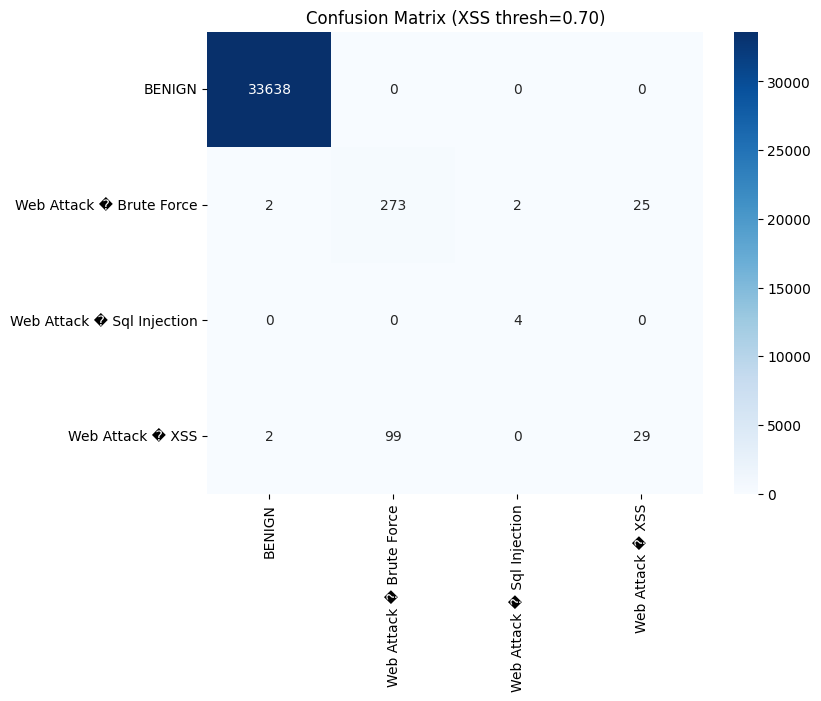

In [ ]:
# Defender Model
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV


# Helper: clean array of NaN/Inf and clip

def clean_array(arr, clip_min=-1e6, clip_max=1e6):
    """
    Replace NaN/Inf with finite bounds and clip values to [clip_min, clip_max].
    """
    arr = np.nan_to_num(arr, nan=0.0, posinf=clip_max, neginf=clip_min)
    return np.clip(arr, clip_min, clip_max)


# Load and clean raw CSV data

# Read CSV, strip whitespace, identify target as last column
df = pd.read_csv(data_path, skipinitialspace=True)
df.columns = df.columns.str.strip()
target = df.columns[-1]

# Coerce features to numeric, handle Inf/NaN, clip extremes
X_df = (
    df.drop(target, axis=1)
      .apply(pd.to_numeric, errors='coerce')
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0)
      .clip(-1e6, 1e6)
)
y_all = df[target].values


# Label-encode target variable

le = joblib.load(ENC_PATH)              # load pre-fit LabelEncoder
y_enc = le.transform(y_all)


# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)
print(f"Split: train={len(y_train)}, test={len(y_test)}")


# Feature scaling with StandardScaler

if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    print("Loaded scaler.")
else:
    scaler = StandardScaler().fit(X_train)
    joblib.dump(scaler, SCALER_PATH)
    print("Saved scaler.")
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# GAN-based augmentation

if os.path.exists(FAKE_PATH):
    # Load synthetic GAN samples and append to training data
    X_fake, y_fake = joblib.load(FAKE_PATH)
    X_aug = np.vstack((X_train_scaled, X_fake))
    y_aug = np.hstack((y_train,       y_fake))
    print(f"Loaded {len(y_fake)} GAN fakes → augmented shape {X_aug.shape}")
else:
    # No GAN samples available, proceed with real data only
    X_aug, y_aug = X_train_scaled, y_train
    print("No GAN fakes found; using only real data.")


# Clean augmented data before oversampling

X_aug = clean_array(X_aug)

# SMOTE oversampling for class imbalance
# Only upsample the Brute-Force to match majority count

print("\nBefore SMOTE:", collections.Counter(y_aug))
brute_idx = next((i for i, cls in enumerate(le.classes_) if "Brute" in cls), None)
if brute_idx is None:
    raise ValueError("Brute-Force class not found!")
target_count = max(collections.Counter(y_aug).values())
sm = SMOTE(random_state=42, sampling_strategy={brute_idx: target_count})
X_res, y_res = sm.fit_resample(X_aug, y_aug)
print("After SMOTE:", collections.Counter(y_res))


# Compute balanced sample weights

sample_weights = class_weight.compute_sample_weight("balanced", y_res)
print("Sample weights by class:", dict(zip(
    np.unique(y_res), np.bincount(sample_weights.astype(int))
)))


# Train XGBoost classifier with class weights

num_classes = len(le.classes_)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
start = time.time()
xgb_model.fit(X_res, y_res, sample_weight=sample_weights)
print(f"Training completed in {time.time()-start:.1f}s")
joblib.dump(xgb_model, MODEL_PATH)
print("Saved class-weighted XGBoost model.")


# 9) Evaluate on held-out test set

print("\n Vanilla Evaluation ")
y_pred = xgb_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4%}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Threshold tuning for XSS class

def predict_with_xss_thresh(probs, thresh=0.70):
    """
    Override predictions: if XSS probability >= thresh, predict XSS
    otherwise choose highest-probability non-XSS class.
    """
    other_idxs = [i for i in range(probs.shape[1]) if i != xss_idx]
    return np.array([
        xss_idx if p[xss_idx] >= thresh else other_idxs[np.argmax(p[other_idxs])]
        for p in probs
    ])

xss_idx = next(i for i, c in enumerate(le.classes_) if "XSS" in c)
probs = xgb_model.predict_proba(X_test_scaled)
for t in [0.50, 0.60, 0.70, 0.80]:
    y_t = predict_with_xss_thresh(probs, t)
    print(f"\n--- Threshold {t:.2f} ---")
    print(classification_report(y_test, y_t, target_names=le.classes_))


# Final confusion matrix (XSS thresh=0.70)

print("\n=== Final Evaluation (XSS thresh=0.70) ===")
y_final = predict_with_xss_thresh(probs, 0.70)
print(classification_report(y_test, y_final, target_names=le.classes_))
cm = confusion_matrix(y_test, y_final)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (XSS thresh=0.70)')
plt.show()

##Attacker Model


  This script trains a GAN based attacker that crafts adversarial network flows
to fool a hardened XGBoost defender. It loads defender artifacts, prepares real
attack data, trains a surrogate classifier, defines GAN components, runs adversarial training with logging, and visualizes results

Loaded label encoder, scaler & XGBoost model.
Prepared attack_tensor, shape torch.Size([2180, 78])
Training surrogate…
  epoch 0: loss=0.6642
  epoch 5: loss=0.5482
Training GAN (200 epochs)…
Epoch 0 | d_loss=1.7192 | g_loss=0.7938 | fool_rate=0.08
Epoch 20 | d_loss=0.8597 | g_loss=0.9028 | fool_rate=1.00
Epoch 40 | d_loss=1.3157 | g_loss=0.8751 | fool_rate=1.00
Epoch 60 | d_loss=0.5647 | g_loss=1.8161 | fool_rate=1.00
Epoch 80 | d_loss=0.7669 | g_loss=1.0581 | fool_rate=1.00
Epoch 100 | d_loss=1.0404 | g_loss=1.2934 | fool_rate=1.00
Epoch 120 | d_loss=0.3767 | g_loss=2.8161 | fool_rate=1.00
Epoch 140 | d_loss=0.6870 | g_loss=1.4159 | fool_rate=1.00
Epoch 160 | d_loss=0.3983 | g_loss=2.0607 | fool_rate=0.31
Epoch 180 | d_loss=0.6416 | g_loss=1.4614 | fool_rate=1.00
Saved GAN generator & discriminator.


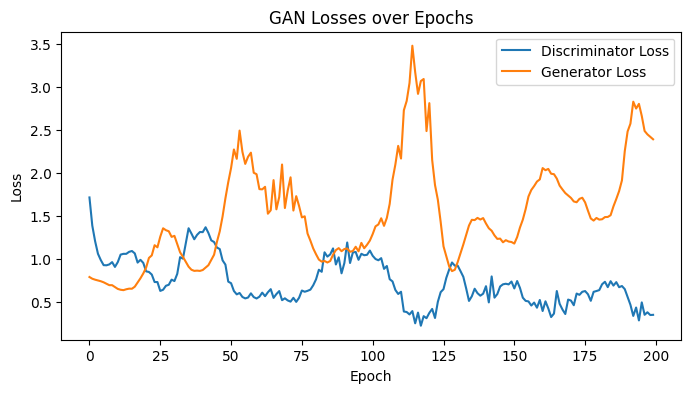

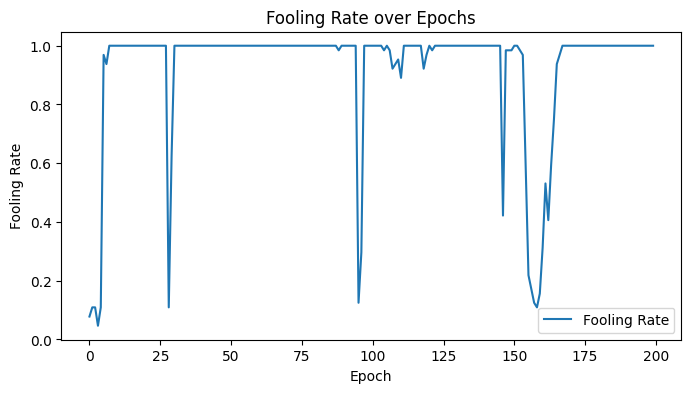

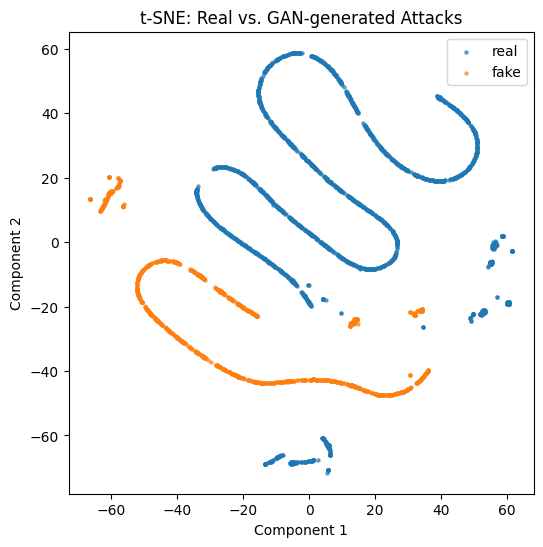

In [ ]:
from sklearn.manifold import TSNE



# Load defender preprocessing & model

# Load the pre-fitted LabelEncoder, StandardScaler, and the XGBoost defender model
label_encoder = joblib.load(ENC_PATH)
scaler_pre    = joblib.load(SCALER_PATH)
xgb_model     = joblib.load(MODEL_PATH)
print("Loaded label encoder, scaler & XGBoost model.")

# Prepare attack tensor

# Read the full dataset, strip whitespace, identify the target column
df_all = pd.read_csv(data_path, skipinitialspace=True)
df_all.columns = df_all.columns.str.strip()
target_col = df_all.columns[-1]

# Separate features and labels
X_all = df_all.drop(target_col, axis=1)
y_all = df_all[target_col]
# Filter only malicious (non-benign) flows
attack_df = df_all[y_all != 'BENIGN']
# Select numeric feature columns for GAN input
attack_feats = attack_df[X_all.columns].select_dtypes(include=[np.number])
# Scale with the defender's scaler to match training distribution
attack_scaled = scaler_pre.transform(attack_feats)

# Convert to torch tensor on chosen device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attack_tensor = torch.tensor(attack_scaled, dtype=torch.float32, device=device)
print(f"Prepared attack_tensor, shape {attack_tensor.shape}")


# 3) Load GAN-augmented data and train surrogate

# The surrogate mimics the defender's BENIGN vs. ATTACK decision boundary
X_res, y_res = joblib.load(AUG_PATH)                    # previously saved fakes + real
benign_idx   = label_encoder.transform(['BENIGN'])[0]    # integer index for BENIGN
# Create binary labels: 1=benign, 0=attack
binary_labels = (y_res == benign_idx).astype(float)

# Define a small MLP as surrogate classifier
input_dim = X_res.shape[1]
surrogate = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

# Prepare tensors and optimizer
X_surr = torch.tensor(X_res, dtype=torch.float32, device=device)
y_surr = torch.tensor(binary_labels, dtype=torch.float32, device=device)
opt_s, loss_s = optim.Adam(surrogate.parameters(), lr=1e-3), nn.BCELoss()

print("Training surrogate…")
for epoch in range(10):
    # Sample mini-batch for surrogate training
    idx = np.random.choice(len(X_surr), 256, replace=False)
    xb, yb = X_surr[idx], y_surr[idx]
    preds = surrogate(xb).squeeze()
    l = loss_s(preds, yb)
    opt_s.zero_grad(); l.backward(); opt_s.step()
    if epoch % 5 == 0:
        print(f"  epoch {epoch}: loss={l.item():.4f}")
# Freeze surrogate to use for GAN loss
surrogate.eval()
for p in surrogate.parameters():
    p.requires_grad = False

# Define Generator & Discriminator

class Generator(nn.Module):
    """Generator network: perturbs real attack flows to create adversarial examples."""
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128), nn.ReLU(),
            nn.Linear(128, 32),  nn.ReLU(),
            nn.Linear(32, 128),  nn.ReLU(),
            nn.Linear(128, dim)
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    """Discriminator network: distinguishes real attack flows from generated ones."""
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 64),  nn.LeakyReLU(0.2),
            nn.Linear(64, 1),    nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Instantiate GAN components
G = Generator(input_dim).to(device)
D = Discriminator(input_dim).to(device)


# Remove old GAN weights if exist

for path in (GEN_PATH, DISC_PATH):
    if os.path.exists(path):
        os.remove(path)

# Initialize logs for loss/fooling metrics
d_losses, g_losses, fool_rates = [], [], []


# Train GAN with surrogate-guided loss

n_epochs = 200
lr = 1e-3
lambda_sur = 0.1                           # weight for surrogate loss in generator
opt_g = optim.Adam(G.parameters(), lr)
opt_d = optim.Adam(D.parameters(), lr)
bce = nn.BCELoss()

print(f"Training GAN ({n_epochs} epochs)…")
for epoch in range(n_epochs):
    # Discriminator update
    batch_idx = np.random.choice(len(attack_tensor), 64, replace=False)
    real = attack_tensor[batch_idx]
    fake = G(real).detach()
    d_real, d_fake = D(real), D(fake)
    loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
    opt_d.zero_grad(); loss_d.backward(); opt_d.step()

    # Generator update
    fake2 = G(real)
    # adversarial loss vs discriminator
    g_loss_d = bce(D(fake2), torch.ones_like(d_fake))
    # surrogate loss to fool defender
    g_loss_s = bce(surrogate(fake2).squeeze(), torch.ones_like(d_real.squeeze()))
    loss_g = g_loss_d + lambda_sur * g_loss_s
    opt_g.zero_grad(); loss_g.backward(); opt_g.step()

    # Log metrics
    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())
    with torch.no_grad():
        fool_rate = (xgb_model.predict(fake2.cpu().numpy()) == benign_idx).mean()
    fool_rates.append(fool_rate)

    # Periodic status print
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | d_loss={loss_d:.4f} | g_loss={loss_g:.4f} | fool_rate={fool_rate:.2f}")

# Save trained GAN weights
torch.save(G.state_dict(), GEN_PATH)
torch.save(D.state_dict(), DISC_PATH)
print("Saved GAN generator & discriminator.")


# Visualize training metrics

# Plot discriminator & generator losses over epochs
plt.figure(figsize=(8,4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot fooling rate over epochs
plt.figure(figsize=(8,4))
plt.plot(fool_rates, label='Fooling Rate')
plt.title('Fooling Rate over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Fooling Rate')
plt.legend()
plt.show()

# t-SNE embedding of real vs. generated samples
real_sample = attack_scaled[:2000]
fakes, _ = joblib.load(FAKE_PATH)
fake_sample = fakes[:2000]
combined = np.vstack((real_sample, fake_sample))
labels = ['real']*len(real_sample) + ['fake']*len(fake_sample)

emb = TSNE(n_components=2, random_state=42).fit_transform(combined)
plt.figure(figsize=(6,6))
for lbl in ['real','fake']:
    mask = np.array(labels) == lbl
    plt.scatter(emb[mask,0], emb[mask,1], label=lbl, s=5, alpha=0.6)
plt.title('t-SNE: Real vs. GAN-generated Attacks')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

##Adversarial Loop


This code orchestrates a closed-loop adversarial training process(5 cycles),
it alternates between retraining/loading a learned XGBoost defender
and generating adversarial network flows via a GAN based attacker

In [ ]:

from xgboost import XGBClassifier
from collections import Counter
import hashlib

# Load the full raw dataset for reference
full_df     = pd.read_csv(data_path, skipinitialspace=True)

# Directory where model weights, scalers, and GAN fakes are stored(Can be found on github)
WEIGHTS_DIR  = '/content/drive/Shareddrives/ML_Final_Project/weights'

# Helpers Functions & Variables
N_CYCLES     = 5     # how many adversarial cycles to run
N_FAKE       = 1000  # how many new fakes to generate each cycle
SMOTE_K      = 5     # k_neighbors for SMOTE
RETRAIN_GAN = 2
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def md5(path):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            h.update(chunk)
    return h.hexdigest()

# Load and clean the raw CSV into X (features), y (labels), and full df
def load_raw():
    df = pd.read_csv(data_path, skipinitialspace=True)
    df.columns = df.columns.str.strip()
    X = df.iloc[:, :-1]\
           .apply(pd.to_numeric, errors='coerce')\
           .replace([np.inf, -np.inf], np.nan)\
           .fillna(0)\
           .clip(-1e6, 1e6)
    y = df.iloc[:, -1].values
    return X, y, df

# Defender training/loading function

def train_defender(force_retrain=False):
    X, y, _ = load_raw()

    # Label-encode
    if force_retrain or not os.path.exists(ENC_PATH):
        le = LabelEncoder().fit(y)
        joblib.dump(le, ENC_PATH)
    else:
        le = joblib.load(ENC_PATH)
    y_enc = le.transform(y)

    # Scale
    if force_retrain or not os.path.exists(SCALER_PATH):
        scaler = StandardScaler().fit(X)
        joblib.dump(scaler, SCALER_PATH)
    else:
        scaler = joblib.load(SCALER_PATH)
    Xs = scaler.transform(X)

    # Train/test split
    Xtr, Xte, ytr, yte = train_test_split(
        Xs, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Augment with previous GAN fakes if any
    if os.path.exists(AUG_PATH):
        Xf, yf = joblib.load(AUG_PATH)
        Xaug  = np.vstack([Xtr, Xf])
        yaug  = np.hstack([ytr, yf])
    else:
        Xaug, yaug = Xtr, ytr

    # SMOTE on all minority classes
    counts    = Counter(yaug)
    max_ct    = max(counts.values())
    strat     = {cls: max_ct for cls, ct in counts.items() if ct < max_ct}
    sm        = SMOTE(random_state=42, k_neighbors=SMOTE_K,
                       sampling_strategy=strat or 'auto')
    Xres, yres = sm.fit_resample(Xaug, yaug)

    # Sample weights for balanced training
    sw = class_weight.compute_sample_weight('balanced', yres)

    # Train or load XGBoost
    if force_retrain or not os.path.exists(MODEL_PATH):
        model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=len(le.classes_),
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            device='cuda' if torch.cuda.is_available() else 'cpu',
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        t0 = time.time()
        model.fit(Xres, yres, sample_weight=sw)
        print(f"Defender retrained in {time.time()-t0:.1f}s  SMOTE→{Counter(yres)}")
        joblib.dump(model, MODEL_PATH)
    else:
        model = joblib.load(MODEL_PATH)
        print("Defender loaded from disk")

    # 8) Return
    acc = model.score(Xte, yte)
    return model, scaler, le, (Xtr, ytr), (Xte, yte), acc


# # Attacker training function

def train_attacker(xgb_model, scaler, le, full_df, cycle, weights_dir):

    """
    Every cycle==1 (first of each run) we retrain the GAN generator
    then we always generate n_fake new adversarial flows, append them to AUG_PATH,
    and return the fooling rate on that batch
    """

    # Build attack tensor from numeric cols
    target_col   = full_df.columns[-1]
    num_cols     = full_df.drop(target_col, axis=1)\
                          .select_dtypes(include=[np.number]).columns
    attack_df    = full_df[full_df[target_col] != 'BENIGN'][num_cols]
    attack_scaled= scaler.transform(attack_df)
    attack_tensor= torch.tensor(attack_scaled, dtype=torch.float32, device=DEVICE)
    print(f"  Prepared attack_tensor, shape {attack_tensor.shape}")

    # Build surrogate model if we have previous AUG_PATH
    benign_idx = le.transform(['BENIGN'])[0]
    if os.path.exists(AUG_PATH):
        Xp, yp = joblib.load(AUG_PATH)
        ybin   = (yp == benign_idx).astype(float)
        surrogate = nn.Sequential(
            nn.Linear(Xp.shape[1], 128), nn.ReLU(),
            nn.Linear(128, 1),            nn.Sigmoid()
        ).to(DEVICE)
        Xs = torch.tensor(Xp, dtype=torch.float32, device=DEVICE)
        ys = torch.tensor(ybin, dtype=torch.float32, device=DEVICE)
        opt_s = optim.Adam(surrogate.parameters(), lr=1e-3)
        loss_s= nn.BCELoss()
        for _ in range(10):
            idx = np.random.choice(len(Xs), 256, replace=False)
            p   = surrogate(Xs[idx]).squeeze()
            l   = loss_s(p, ys[idx])
            opt_s.zero_grad(); l.backward(); opt_s.step()
        surrogate.eval()
    else:
        # fallback, use defender itself as surrogate
        def surrogate(x):
            preds = xgb_model.predict(x.detach().cpu().numpy())
            return torch.tensor((preds == benign_idx).astype(float),
                                dtype=torch.float32, device=DEVICE)

    # Define GAN generator
    generator = nn.Sequential(
        nn.Linear(attack_tensor.size(1), 128), nn.ReLU(),
        nn.Linear(128, 32),                    nn.ReLU(),
        nn.Linear(32, 128),                    nn.ReLU(),
        nn.Linear(128, attack_tensor.size(1))
    ).to(DEVICE)

    # Train or load GAN generator on cycle==1
    if cycle % N_CYCLES == 1 or not os.path.exists(GEN_PATH):
        print("  → Training GAN generator from scratch…")
        opt_g  = optim.Adam(generator.parameters(), lr=1e-3)
        loss_g = nn.BCELoss()
        for epoch in range(100):
            idx  = np.random.choice(len(attack_tensor), 64, replace=False)
            real = attack_tensor[idx]
            fake = generator(real)
            preds= surrogate(fake).squeeze()
            tgt  = torch.ones_like(preds)
            l    = loss_g(preds, tgt)
            opt_g.zero_grad(); l.backward(); opt_g.step()
            if epoch % 20 == 0:
                print(f"    Epoch {epoch}: loss={l.item():.4f}, fool_rate={preds.mean():.2f}")
        torch.save(generator.state_dict(), GEN_PATH)
        print("GAN generator saved")
    else:
        generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
        print("GAN generator loaded")

    # Generate N_FAKE adversarial flows
    generator.eval()
    with torch.no_grad():
        idx       = torch.randint(0, attack_tensor.size(0), (N_FAKE,), device=DEVICE)
        new_fakes = generator(attack_tensor[idx]).cpu().numpy()

    # Append and save to AUG_PATH
    attack_label = attack_df.index.name  # mode of the label column
    attack_label = full_df.loc[attack_df.index, target_col].mode()[0]
    attack_idx   = le.transform([attack_label])[0]
    y_fakes      = np.full(len(new_fakes), attack_idx, dtype=int)

    if os.path.exists(AUG_PATH):
        Xp, yp = joblib.load(AUG_PATH)
        Xn, yn = np.vstack([Xp, new_fakes]), np.hstack([yp, y_fakes])
    else:
        Xn, yn = new_fakes, y_fakes

    joblib.dump((Xn, yn), AUG_PATH)
    print(f"  ⏺ Saved {len(y_fakes)} new GAN fakes → pool now {len(yn)}")

    # Compute fooling rate
    preds     = xgb_model.predict(new_fakes)
    fool_rate = np.mean(le.inverse_transform(preds) == 'BENIGN')
    return fool_rate


# Adversarial Loop

results = []
last_hash = None
X, y, full_df = load_raw()

for cycle in range(1, N_CYCLES + 1):
    print(f"\n Cycle {cycle}/{N_CYCLES} ")
    cur_hash = md5(AUG_PATH) if os.path.exists(AUG_PATH) else None
    retrain  = (cur_hash != last_hash)
    last_hash = cur_hash

    print("→ Defender:", "retrain" if retrain else "load")
    mdl, scl, le, (Xtr,ytr), (Xte,yte), acc = train_defender(force_retrain=retrain)
    print(f"  [Defender] test acc = {acc:.4%}")

    fool = train_attacker(mdl, scl, le, full_df, cycle, WEIGHTS_DIR)
    print(f"  [Attacker] fooling rate = {fool:.2%}")

    results.append({'cycle': cycle, 'def_acc': acc, 'att_fool': fool})

print("\nSummary:")
print(pd.DataFrame(results))


 Cycle 1/5 
→ Defender: retrain


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:15:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Defender retrained in 11.2s  SMOTE→Counter({np.int64(0): 270096, np.int64(1): 270096, np.int64(3): 270096, np.int64(2): 270096})
  [Defender] test acc = 99.6273%
  Prepared attack_tensor, shape torch.Size([2180, 78])
  → Training GAN generator from scratch…
    Epoch 0: loss=0.6778, fool_rate=0.51
    Epoch 20: loss=0.0474, fool_rate=0.96
    Epoch 40: loss=0.0006, fool_rate=1.00
    Epoch 60: loss=0.0001, fool_rate=1.00
    Epoch 80: loss=0.0000, fool_rate=1.00
GAN generator saved
  ⏺ Saved 1000 new GAN fakes → pool now 560192
  [Attacker] fooling rate = 91.20%

 Cycle 2/5 
→ Defender: retrain


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:17:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Defender retrained in 11.3s  SMOTE→Counter({np.int64(0): 270096, np.int64(1): 270096, np.int64(3): 270096, np.int64(2): 270096})
  [Defender] test acc = 99.6449%
  Prepared attack_tensor, shape torch.Size([2180, 78])
GAN generator loaded
  ⏺ Saved 1000 new GAN fakes → pool now 561192
  [Attacker] fooling rate = 0.00%

 Cycle 3/5 
→ Defender: retrain


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:18:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Defender retrained in 11.5s  SMOTE→Counter({np.int64(0): 270096, np.int64(1): 270096, np.int64(3): 270096, np.int64(2): 270096})
  [Defender] test acc = 99.6361%
  Prepared attack_tensor, shape torch.Size([2180, 78])
GAN generator loaded
  ⏺ Saved 1000 new GAN fakes → pool now 562192
  [Attacker] fooling rate = 0.00%

 Cycle 4/5 
→ Defender: retrain


##Artifact - Data Exploration (Deprecated)
This section of the code was created to give us a better understanding of the data that we had

In [ ]:
# Find misclassified samples
misclassified_indices = np.where(y_pred_xgb != y_test)[0]

# Map encoded labels back to original strings
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

# Create a DataFrame to inspect misclassifications
misclassified_df = pd.DataFrame({
    'True Label': y_test_labels[misclassified_indices],
    'Predicted Label': y_pred_labels[misclassified_indices]
})

print(f"\nNumber of misclassified samples: {len(misclassified_df)}")
print("Sample misclassifications:")
print(misclassified_df.sample(10))  # Show a random sample of 10 misclassifications

from sklearn.metrics import ConfusionMatrixDisplay

# Normalize confusion matrix by true label (row)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                              display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()


NameError: name 'np' is not defined